In [31]:
from analytics import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
experiment_dir = p/"bba_28_cs1.2"
reference_path = Path("/projects/RL-fold/msalim/SC20-GB-CS1-ThetaGPU-AI-driven-MD/data/1FME/1FME-folded.pdb")
data = analyze_md_runs(
    experiment_dir,
    reference_path,
    select="protein and name CA",
    cutoff=8.0,
    in_memory=True,
)

16227it [23:07, 11.69it/s]


In [54]:
import json
json_save = Path(".").resolve().joinpath("contact_rmsd.json")
with open(json_save, "w") as f:
    json.dump(data, f)

In [76]:
from collections import defaultdict
def gather_data(data):
    iteration_data = defaultdict(list)
    for md_run_data in data:
        run_iter = Path(md_run_data[0]["dcd_file"]).with_suffix("").name.split("_")[1]
        iteration_data[run_iter].extend(md_run_data)

    # {run_iter(000001): [[dicts]]}
    return iteration_data

In [77]:
gathered_data = gather_data(data)

In [78]:
rmsd_stats = {"min": [], "max": [], "mean": []}
contact_stats = {"min": [], "max": [], "mean": []}
import pandas as pd

for iteration_data in gathered_data.values():
    
    df = pd.DataFrame(iteration_data)
    
    rmsd_stats["mean"].append(df.rmsd.mean())
    rmsd_stats["min"].append(df.rmsd.min())
    rmsd_stats["max"].append(df.rmsd.max())
    
    contact_stats["mean"].append(df.contact.mean())
    contact_stats["min"].append(df.contact.min())
    contact_stats["max"].append(df.contact.max())
    

In [80]:
rmsd_df = pd.DataFrame(rmsd_stats)
contact_df = pd.DataFrame(contact_stats)

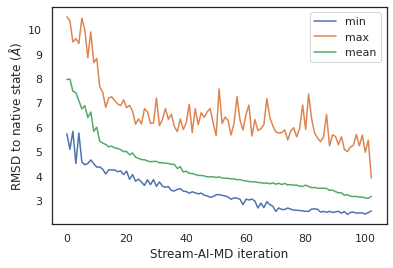

In [95]:
rmsd_df.plot(
    ylabel=r"RMSD to native state $(\AA)$",
    xlabel="Stream-AI-MD iteration",
)
plt.legend(facecolor=LEGEND_FACECOLOR)
rmsd_df.describe()
save_fig("rmsd_timeseries_bba_28_cs1.2")

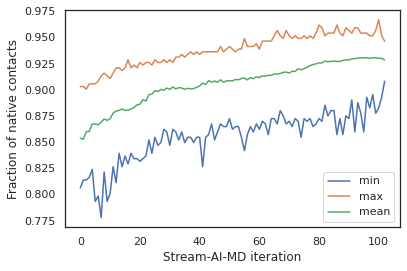

In [96]:
contact_df.plot(
    ylabel=r"Fraction of native contacts",
    xlabel="Stream-AI-MD iteration",
)
plt.legend(facecolor=LEGEND_FACECOLOR)
contact_df.describe()
save_fig("contact_timeseries_bba_28_cs1.2")

# Get best PDBs

In [4]:
import json
json_save = Path(".").resolve().joinpath("contact_rmsd.json")
with open(json_save, "r") as f:
    data = json.load(f)

In [20]:
# Get lowest RMSD
best_rmsd_conformer = min(
    itertools.chain(*data),
    key=lambda x: x["rmsd"],
)

# Get largest fraction of native contacts
best_contact_conformer = max(
    itertools.chain(*data),
    key=lambda x: x["contact"],
)

In [21]:
best_rmsd_conformer

{'rmsd': 2.4320826733213172,
 'contact': 0.9464285714285714,
 'frame': 162,
 'pdb_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0085_000095/run0047_000092__system__198.pdb',
 'dcd_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0085_000095/run0085_000095.dcd'}

In [23]:
best_contact_conformer

{'rmsd': 3.6960150191427883,
 'contact': 0.9668367346938775,
 'frame': 119,
 'pdb_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0049_000101/run0040_000099__system__33.pdb',
 'dcd_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0049_000101/run0049_000101.dcd'}

In [35]:
here = Path("/lus/theta-fs0/projects/RL-fold/braceal/src/PASC21-Stream-AI-MD/")

write_pdb(
    output_pdb=here.joinpath("pdbs/bba/1FME_best_rmsd.pdb").as_posix(),
    input_pdb=best_rmsd_conformer["pdb_file"],
    traj_file=best_rmsd_conformer["dcd_file"],
    frame=best_rmsd_conformer["frame"],
)

write_pdb(
    output_pdb=here.joinpath("pdbs/bba/1FME_best_contact.pdb").as_posix(),
    input_pdb=best_contact_conformer["pdb_file"],
    traj_file=best_contact_conformer["dcd_file"],
    frame=best_contact_conformer["frame"],
)